In [1]:
import numpy as np
import heapq
# import pandas as pd
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse.csgraph import dijkstra

import matplotlib.pyplot as plt

from time import time

In [2]:
# Semicircular track parameters
INNER_RADIUS = 7
OUTER_RADIUS = 10

# Mesh parameters, H ~ radial, K ~ arc
H = 24
K = 128

# Mesh

## Old approach

In [3]:
# track_iter = np.zeros((2,H))
# track_iter[0,:] = np.linspace(INNER_RADIUS, OUTER_RADIUS, H)
# pd.DataFrame(track_iter)

In [4]:
# def iterate_track_arc(theta, track_iter):
#     R = np.array([[np.cos(theta), -np.sin(theta)],
#                   [np.sin(theta),  np.cos(theta)]])
    
#     next_track_iter = R@track_iter
#     nondiag_distances = np.linalg.norm(next_track_iter - track_iter, axis=0)

#     return next_track_iter, nondiag_distances

In [5]:
# track_iter, nondiag_distances = iterate_track_arc(np.pi/K, track_iter)
# diag_distances = None
# pd.DataFrame(nondiag_distances)

## New approach

The previous approach was based on the idea of computing entries in the weighted adjacency matrix during each iteration, possibly reusing the cos/sin calculations while computing the norm.
I determined that this would probably have negligible gains, if any at all, over the more modular/readable style of computing the mesh first, then the weighted adjacency matrix after.

The following is a simple, partially vectorized method to compute the mesh. Not much to say about it, I chose to vectorize along the larger dimension K to reduce iteration.

In [6]:
def arc(thetas, radius):
    return radius * np.array([np.cos(thetas),np.sin(thetas)])

In [7]:
thetas = np.linspace(0, np.pi, K)
radii = np.linspace(INNER_RADIUS, OUTER_RADIUS, H)
# print(arc(thetas[:-1], radii[H-1]))

mesh = np.zeros((2,K,H))
for i, radius in enumerate(radii):
    mesh[:,:,i] = arc(thetas, radius)

#mesh[:,20,40]

## Mesh Sanity Check

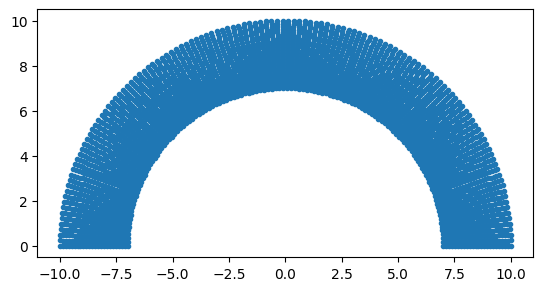

In [8]:
# Flatten the x,y coords
x = np.ravel(mesh[0,:,:])
y = np.ravel(mesh[1,:,:])

# Display the mesh, hopefully a semicircular ring
plt.scatter(x, y, marker='.')
plt.gca().set_aspect('equal')
plt.show()

# Adjacency matrix

For any fixed value of theta, the distance between adjacent points on the radial axis is constant. ||*|| is direct forward distance as seen in older method above, ||**|| is diag distance

|          | (th0,r0) | (th0,r1) | ... | (th0,rH) | (th1,r0)   | ... | ... | (thK,rH) |
|----------|----------|----------|-----|----------|------------|-----|-----|----------|
| (th0,r0) | 0        | (OUTER-INNER)/H     | ... | 0        | \|\|*\|\|  |     |     |          |
| (th0,r1) |          | 0        | ... |          | \|\|**\|\| |     |     |          |
| ...      |          |          |     |          |            |     |     |          |

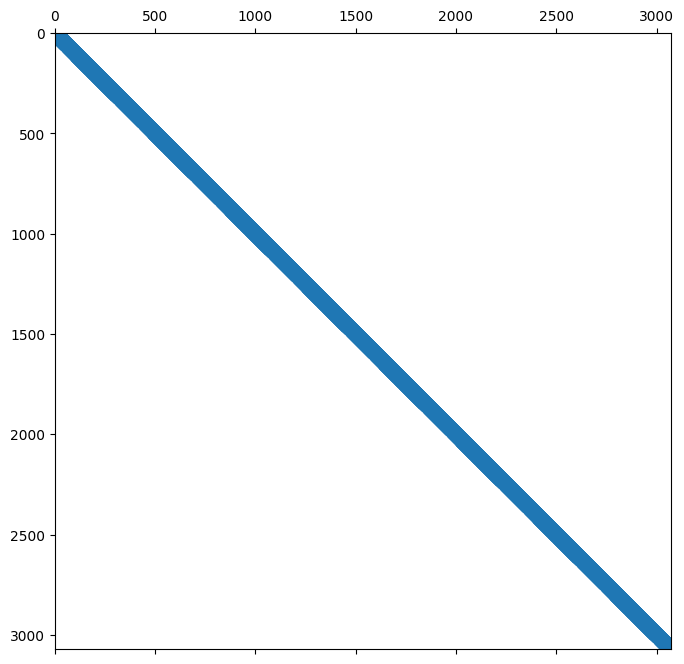

In [9]:
weighted_adj = np.zeros((H*K,H*K))

for theta_i, radius_i in np.ndindex(mesh.shape[1:]):
    # Current index, flattened for adjacency matrix entry
    adj_i = H*theta_i + radius_i

    if radius_i != H-1:  # Not on outer edge (covers all radial)
        
        # Exact radial distance value
        weighted_adj[adj_i,adj_i+1] = np.pi / H
        
    if theta_i != K-1:  # Not at end of track segment (prereq for forward/diagonal)

        # Inner diagonal motion
        if radius_i != 0:
            inner_diag = mesh[:,theta_i+1,radius_i-1] - mesh[:,theta_i,radius_i]
            weighted_adj[adj_i , adj_i + H-1] = np.linalg.norm(inner_diag)
            
        # Direct forward motion
        forward = mesh[:,theta_i+1,radius_i] - mesh[:,theta_i,radius_i]
        weighted_adj[adj_i , adj_i + H] = np.linalg.norm(forward)

        # Outer diagonal motion
        if radius_i != H-1:
            outer_diag = mesh[:,theta_i+1,radius_i+1] - mesh[:,theta_i,radius_i]
            weighted_adj[adj_i , adj_i + H+1] = np.linalg.norm(outer_diag)

# Mirror upper triangular to lower triangular for accurate bidirectional adjacency matrix
weighted_adj = csr_matrix(weighted_adj + weighted_adj.T - np.diag(np.diag(weighted_adj)))

plt.figure(figsize=(8,8))
plt.spy(weighted_adj, marker='.')
plt.show()

In [10]:
#print(weighted_adj)

# Shortest Path

scipy includes an implementation of Dijkstra's Algorithm, which will give me the shortest path with no additional implementation required, assuming the weighted adjacency matrix is correct.

In [11]:
# source = H-1
# dest = H*K - 1
# dist_matrix, predecessors = dijkstra(weighted_adj, directed=False, indices=source, return_predecessors=True)

In [12]:
# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.shortest_path.html#scipy.sparse.csgraph.shortest_path
# # Reconstruct the shortest path
# curr_node = dest
# shortest_path = []
# while curr_node != -9999:
#     shortest_path = [curr_node] + shortest_path
#     curr_node = int(predecessors[curr_node])

In [13]:
# # Reconstruct (theta, radius) mesh indices from adjacency matrix indices
# shortest_path_tt = [i//H for i in shortest_path]
# shortest_path_rd = [i%H  for i in shortest_path]

# # Get the lists of coordinates corresponding to the nodes along the shortest path
# shortest_path_x = np.array([float(x) for x in mesh[0,shortest_path_tt,shortest_path_rd]])
# shortest_path_y = np.array([float(y) for y in mesh[1,shortest_path_tt,shortest_path_rd]])

In [14]:
def shortest_path_dijkstra(sparse_adj_matrix, source, dest):
    # Do Dijkstra's, get shortest path length to dest
    dist_matrix, predecessors = dijkstra(weighted_adj, directed=False, indices=source, return_predecessors=True)
    shortest_path_length = dist_matrix[dest]

    # Reconstruct the shortest path
    curr_node = dest
    shortest_path = []
    while curr_node != -9999:
        shortest_path = [curr_node] + shortest_path
        curr_node = int(predecessors[curr_node])

    # Reconstruct (theta, radius) mesh indices from adjacency matrix indices
    shortest_path_tt = [i//H for i in shortest_path]
    shortest_path_rd = [i%H  for i in shortest_path]
    
    # Get the lists of coordinates corresponding to the nodes along the shortest path
    shortest_path_x = np.array([float(x) for x in mesh[0,shortest_path_tt,shortest_path_rd]])
    shortest_path_y = np.array([float(y) for y in mesh[1,shortest_path_tt,shortest_path_rd]])

    return (shortest_path_length, shortest_path, shortest_path_x, shortest_path_y)

## Greedy optimal path (A*)

Dijkstra's algorithm works, but it's designed to fully map out all shortest paths from sources to all possible destinations. For this use case, A* should provide a substantial speedup, which is important for realtime systems such as navigation. In an actual mapping case where the domain is updated with time, I saw there are iterative heuristic algorithms such as [D* Lite](https://idm-lab.org/bib/abstracts/papers/aaai02b.pdf) that sees use in robotics applications, but for our fixed domain that is unnecessary.

In [15]:
# shortest_path, cost = a_star_adjacency(weighted_adj, mesh, H-1, H*K-1)
# print(shortest_path)
# print(cost)
def a_star():
    pass

def shortest_path_a_star(sparse_adj_matrix, mesh, source, dest):
    pass

In [16]:
source = H-1
dest = H*K - 1

dijkstra_time = []
# a_star_time = []
for _ in range(10000):
    start = time()
    shortest_path_dijkstra(weighted_adj, source, dest)
    end = time()
    dijkstra_time.append(end-start)

# for _ in range(10000):
    # start = time()
    # shortest_path_a_star(weighted_adj, mesh, source, dest)
    # end = time()
    # a_star_time.append(end-start)

print(f"Dijkstra Execution Time: {1000*np.mean(dijkstra_time)} ms")
# print(f"A* Execution Time: {1000*np.mean(a_star_time)} ms")

Dijkstra Execution Time: 0.3868027448654175 ms


## Plot the shortest path

In [17]:
source = H-1
dest = H*K - 1
shortest_path_length, shortest_path, shortest_path_x, shortest_path_y = shortest_path_dijkstra(weighted_adj, source, dest)
# shortest_path_length, shortest_path, shortest_path_x, shortest_path_y = shortest_path_a_star()
print(shortest_path)
print(shortest_path_length)

[23, 46, 69, 92, 115, 138, 161, 184, 207, 230, 253, 276, 299, 322, 345, 368, 391, 414, 437, 460, 483, 506, 529, 552, 576, 600, 624, 648, 672, 696, 720, 744, 768, 792, 816, 840, 864, 888, 912, 936, 960, 984, 1008, 1032, 1056, 1080, 1104, 1128, 1152, 1176, 1200, 1224, 1248, 1272, 1296, 1320, 1344, 1368, 1392, 1416, 1440, 1464, 1488, 1512, 1536, 1560, 1584, 1608, 1632, 1656, 1680, 1704, 1728, 1752, 1776, 1800, 1824, 1848, 1872, 1896, 1920, 1944, 1968, 1992, 2016, 2040, 2064, 2088, 2112, 2136, 2160, 2184, 2208, 2232, 2256, 2280, 2304, 2328, 2352, 2376, 2400, 2424, 2448, 2472, 2496, 2521, 2546, 2571, 2596, 2621, 2646, 2671, 2696, 2721, 2746, 2771, 2796, 2821, 2846, 2871, 2896, 2921, 2946, 2971, 2996, 3021, 3046, 3071]
25.41899949571509


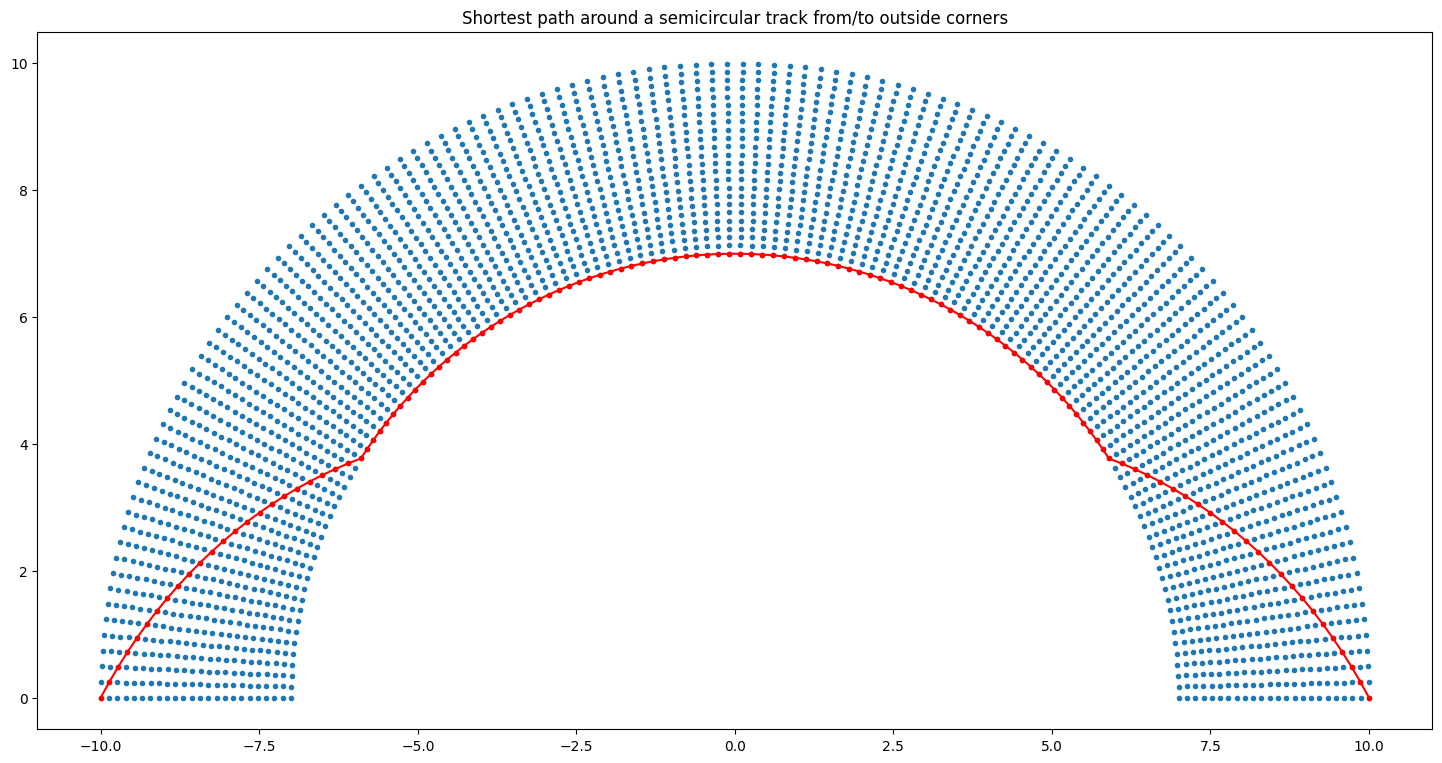

In [18]:
plt.figure(figsize=(18,18))
plt.scatter(x, y, marker='.')
plt.plot(shortest_path_x, shortest_path_y, color='r')
plt.scatter(shortest_path_x, shortest_path_y, color='r', marker='.')
plt.title("Shortest path around a semicircular track from/to outside corners")
plt.gca().set_aspect('equal')
plt.show()